# Sync Code

Clone the GitHub Repo


In [ ]:
!cd /content
!git clone https://github.com/szappac20/training_camp_21_22.git -b develop

Cloning into 'training_camp_21_22'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 39 (delta 13), reused 31 (delta 8), pack-reused 0
Unpacking objects: 100% (39/39), done.


`Move to the Python Project root folder` and install requirements

In [ ]:
%cd /content/training_camp_21_22
%pip install --upgrade -r requirements.txt -qqq

/content/training_camp_21_22
     |████████████████████████████████| 38.1 MB 12.9 MB/s 
     |████████████████████████████████| 9.8 MB 59.5 MB/s 
     |████████████████████████████████| 511.7 MB 6.5 kB/s 
     |████████████████████████████████| 554 kB 49.2 MB/s 
     |████████████████████████████████| 13.1 MB 43.2 MB/s 
     |████████████████████████████████| 1.1 MB 44.6 MB/s 
     |████████████████████████████████| 15.8 MB 44.4 MB/s 
     |████████████████████████████████| 5.8 MB 49.8 MB/s 
     |████████████████████████████████| 1.6 MB 44.4 MB/s 
     |████████████████████████████████| 438 kB 56.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Download Dataset from Kaggle competition

Download dataset from Kaggle competition pitc-2122-clustering

In [ ]:
!mkdir -p ~/.kaggle

Download the kaggle.json token file

In [ ]:
#!gdown 1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN -O  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Download the input file (training and test)

In [ ]:
!mkdir -p data/task_1

In [ ]:
%cd data/task_1

/content/training_camp_21_22/data/task_1


In [ ]:
!kaggle competitions download -c pitc-2122-clustering
!unzip pitc-2122-clustering.zip

 99% 23.0M/23.1M [00:00<00:00, 239MB/s]
100% 23.1M/23.1M [00:00<00:00, 238MB/s]
Archive:  pitc-2122-clustering.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22
/content/training_camp_21_22


# Import packages

Move back to the Python project folder 

In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


Set the Python Path variable to the source folder

In [ ]:
import sys
import os

sys.path.append("training_camp_21_22")

Import libraries

In [ ]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import csv

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
import tensorflow_decision_forests as tfdf

import training_camp_21_22.config
import training_camp_21_22.data.commercial_offer
import training_camp_21_22.models
import training_camp_21_22.view.classification

# Preprocess Data

Dowload the data

In [ ]:
# Parse the csv file with json entries

def convert_json_2_pd(json_input_path, train = True):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """
    d = {}
    labels = {}
    i = 0
    j = 0
    with open(json_input_path) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)

        for row in tqdm(reader):
          # iterate through bill

          for bill in json.loads(row[-1]) :
            # read consumer id
            id = row[0]
            # birth date
            birth_date = bill['bamData']['items']['bamItem']['personInfo']['birthDate']

            # billing_range
            billing_range = bill['customData']['billing_range']
            # energy
            energy = bill['customData']['energy']
            # addresses
            addresses = bill['bamData']['items']['bamItem']['addresses']
            
            res_address_code = ''
            res_address_value = ''
            dom_address_code = ''
            dom_address_value = ''

            # build the fields
            for addr in addresses:
              if(addr['type']['code'] == '2'):
                res_address_code = addr['city']['code']
                res_address_value = addr['city']['value']
              elif(addr['type']['code'] == '6'):
                dom_address_code = addr['city']['code']
                dom_address_value = addr['city']['value']
            
            # store information of bill into dictionary
            d[i] = {
              'userID' : id,
              'Age': 2022 - int(birth_date[:4]),
              'legalNature' : bill['bamData']['items']['bamItem']['legalNature'],
              'citizenshipNoUSA' : bill['bamData']['items']['bamItem']['personInfo']['citizenshipNoUSA'],
              'billing_range.from_date' : billing_range['from_date'],
              'billing_range.to_date' : billing_range['to_date'],
              'f1' : energy['fasciaF1ConsumoFatturato'],
              'f2' : energy['fasciaF2ConsumoFatturato'],
              'f3' : energy['fasciaF3ConsumoFatturato'],
              'res_address_code': res_address_code,
              'res_address_value': res_address_value,
              'dom_address_code': dom_address_code,
              'dom_address_value': dom_address_value
            }
            i = i+1
          # create dataframe of labels (only for the training data)
          if(train):
            labels[j] = {'userID' : row[0] , 'cluster': int(row[1])}
            j += 1


    if(train):
      return pd.DataFrame.from_dict(d, "index"), pd.DataFrame.from_dict(labels, 'index')
    return  pd.DataFrame.from_dict(d, "index")

features_df, labels_df = convert_json_2_pd(json_input_path="/content/training_camp_21_22/data/task_1/train.csv", train = True)

Let's have a look at the collected data!

In [ ]:
features_df.head()

,userID,legalNature,citizenshipNoUSA,billing_range.from_date,billing_range.to_date,f1,f2,f3,res_address_code,res_address_value,dom_address_code,dom_address_value
0,90019,PF,False,2021-11-01,2021-11-30,30.0,31.0,14.0,B794,Carmignano,B794,Carmignano
1,90019,PF,False,2021-08-01,2021-08-31,2.0,41.0,7.0,B794,Carmignano,B794,Carmignano
2,90025,PF,False,2022-02-01,2022-02-28,49.0,11.0,39.0,C422,Ceggia,C422,Ceggia
3,90025,PF,False,2021-08-01,2021-08-31,18.0,50.0,61.0,C422,Ceggia,C422,Ceggia
4,90030,PF,False,2022-06-01,2022-06-30,18.0,33.0,36.0,D170,Crispano,D170,Crispano


In [ ]:
labels_df.head()

,user,cluster
0,6,1
1,13,0
2,14,1
3,17,2
4,34,2


Load the commercial offers

In [ ]:
#Label 0
mono_oraria = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.28, "f2": 0.28, "f3": 0.28}, name="mono_oraria")

# Label 1
serale = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.31, "f2": 0.26, "f3": 0.26}, name="serale")

# Lael 2
notturna = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.56, "f2": 0.56, "f3": 0.}, name="notturna")

commercial_offers = [mono_oraria, serale, notturna]
class_names = [co.name for co in commercial_offers]

#Baseline Classifier

The label is computed by "extending" the mean consumptions over the whole year

In [ ]:
def project_over_year(df, commercial_offers):
    
    def best_projected_offer(row):
        columns = [co.name for co in commercial_offers]
        cluster = np.argmin(row[columns])
        return cluster
        
    year_projection = 12 * df.groupby(by=["userID"]).mean()

    for offer in commercial_offers:
        year_projection[offer.name] = year_projection.apply(
            offer.compute_yearly_cost, axis=1)

    year_projection["cluster"] = year_projection.apply(
        best_projected_offer, axis=1)
    year_projection = year_projection.drop(
        [co.name for co in commercial_offers], axis=1)

    return year_projection


year_projection_df = project_over_year(
    features_df, commercial_offers)

Let's have a look at the projection!

In [ ]:
year_projection_df.head()

,citizenshipNoUSA,f1,f2,f3,cluster
userID,,,,,
0,0.0,228.0,572.0,440.0,1
1,0.0,12.0,528.0,444.0,1
10,0.0,508.0,176.0,796.0,2
100,0.0,648.0,36.0,960.0,2
1000,0.0,396.0,654.0,102.0,1


Plotting the confusion matrix

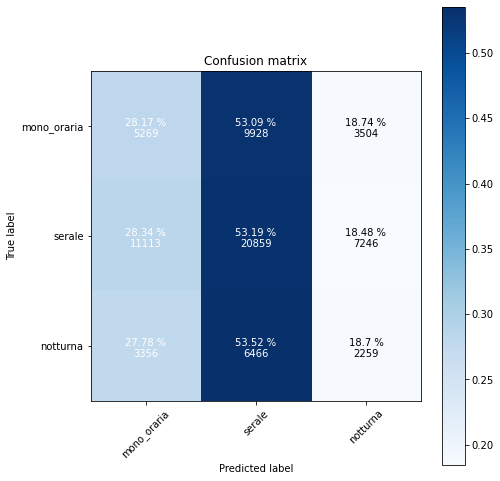

In [ ]:
cm = confusion_matrix(
    labels_df["cluster"], year_projection_df["cluster"])

# Log the confusion matrix as an image summary
figure = training_camp_21_22.view.classification.plot_cm_with_labels(
    cm, class_names=class_names);

# Random Forest Classifier

Random Forest model

First of all, we extract the data about the bills by using the previously defined function

In [ ]:
train_df, labels_df = convert_json_2_pd(json_input_path = '/content/training_camp_21_22/data/task_1/train.csv')
test_df = convert_json_2_pd(json_input_path = '/content/training_camp_21_22/data/task_1/test.csv', train= False)

70000it [00:20, 3337.06it/s]
10000it [00:03, 3323.28it/s]


After some trials, we found that the relevant features we are going to consider in order to train our model and obtain optimal results are:

- mean consumptions (f1,f2,f3)
- residence and domicile address of the customer
- age of the customer


In [ ]:
## in order to implement a random forest classifier we need only numerical values!

ord_enc = OrdinalEncoder()

# we therefore proceed to translate the data in numerical values (train)

train_df["res_address_code"] = ord_enc.fit_transform(train_df[["res_address_code"]])
train_df["res_address_value"] = ord_enc.fit_transform(train_df[["res_address_value"]])
train_df["dom_address_code"] = ord_enc.fit_transform(train_df[["dom_address_code"]])
train_df["dom_address_value"] = ord_enc.fit_transform(train_df[["dom_address_value"]])

# we therefore proceed to translate the data in numerical values (test)

test_df["res_address_code"] = ord_enc.fit_transform(test_df[["res_address_code"]])
test_df["res_address_value"] = ord_enc.fit_transform(test_df[["res_address_value"]])
test_df["dom_address_code"] = ord_enc.fit_transform(test_df[["dom_address_code"]])
test_df["dom_address_value"] = ord_enc.fit_transform(test_df[["dom_address_value"]])

# compute mean consumptions by user
train_df = train_df.groupby(by = 'userID').mean().reset_index()
# attach labels to training features
train_df = pd.merge(train_df, labels_df, on='userID', how='outer')
# keep only selected features
train_df = train_df.drop(columns = ["userID", "billing_range.from_date", "billing_range.to_date", 'legalNature', 'citizenshipNoUSA'])
test_df = test_df.groupby(by = 'userID').mean().reset_index()
user_ids = test_df["userID"]
test_df = test_df.drop(columns= ["userID", "billing_range.from_date", "billing_range.to_date", 'legalNature', 'citizenshipNoUSA'])

Let's have a quick look at our training features.

In [ ]:
train_df.head()

,Age,f1,f2,f3,res_address_code,res_address_value,dom_address_code,dom_address_value,cluster
0,42.0,19.000000,47.666667,36.666667,3648.0,3672.0,2909.0,2936.0,1
1,35.0,1.000000,44.000000,37.000000,5682.0,5732.0,4534.0,4583.0,1
2,31.0,42.333333,14.666667,66.333333,913.0,919.0,1633.0,1636.0,2
3,42.0,54.000000,3.000000,80.000000,5328.0,5368.0,4273.0,4312.0,2
4,74.0,33.000000,54.500000,8.500000,2280.0,2280.0,309.0,306.0,1


Now we create and train our model using TensorFlow.

In [ ]:
# Convert the dataset into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="cluster")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [ ]:
# Train a Random Forest model
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

Use /tmp/tmpn8yirxrv as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.534595. Found 70000 examples.
Training model...
Model trained in 0:01:24.882749
Compiling model...
Model compiled.


In [ ]:
model.summary()

Model: "random_forest_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (8):
	Age
	dom_address_code
	dom_address_value
	f1
	f2
	f3
	res_address_code
	res_address_value

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL" 13.082605 ################
    2. "res_address_value" 11.564092 #############
    3.  "dom_address_code" 11.548148 #############
    4. "dom_address_value" 11.528808 #############
    5.  "res_address_code" 11.510107 #############
    6.                "f2"  2.673909 #
    7.                "f3"  2.594090 #
    8.               "Age"  2.127593 
    9.                "f1"  1.477616 

Variable Importance: NUM_AS_ROOT:
    1.               "Age" 124.000000 ####

After training, we make our predictions on the test data to make our submission.

In [ ]:
predictions = np.argmax(model.predict(test_ds), axis=1)

10/10 [==============================] - 2s 164ms/step


# Submit solution to Kaggle competition

In [ ]:
# baseline submission
test_submission = pd.DataFrame({
    "user": year_projection_df.index,
    "cluster": year_projection_df["cluster"]})
print(test_submission.head(10))
print(test_submission.shape)

         user  cluster
userID                
90000   90000        2
90001   90001        2
90002   90002        1
90003   90003        0
90004   90004        1
90005   90005        1
90006   90006        0
90007   90007        0
90008   90008        1
90009   90009        1
(10000, 2)


In [ ]:
# Random Forest submission
test_submission = pd.DataFrame({
    "user": user_ids.values,
    "cluster": predictions})
print(test_submission.head(10))
print(test_submission.shape)

    user  cluster
0  90000        2
1  90001        1
2  90002        1
3  90003        0
4  90004        1
5  90005        1
6  90006        0
7  90007        0
8  90008        1
9  90009        1
(10000, 2)


Create a termporary folder for submissions

In [ ]:
!mkdir -p submissions

In [ ]:
rf_labels_path = "submissions/baseline.csv"
test_submission.to_csv(rf_labels_path, index=False)

In [ ]:
!kaggle competitions submit -c pitc-2122-clustering -f "submissions/baseline.csv" -m "Random Forest classification"

100% 78.1k/78.1k [00:02<00:00, 33.4kB/s]
Successfully submitted to PITC 21/22 - Clustering